In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import preprocess, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, SpaceSampler
from hython.metrics import mse_metric

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset


from hython.utils import missing_location_idx, reconstruct_from_missing

from hython.models.lstm import CustomLSTM


# viz
import matplotlib.pyplot as plt
#import hvplot.xarray 
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

In [164]:
wd = Path("../data/datademo")
fp_dynamic_forcings = wd / "forcings.nc"
fp_wflow_static_params = wd / "staticmaps.nc"
fp_target = wd / "output.nc"


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc", "actevap" ]


timeslice = slice("2016-01-01","2020-12-31")


### HYPERPARAMETERS

# training 

spatial_batch_size = 128*4
temporal_sampling_size = 200
seq_length = 260

# model 

hidden_size = 8

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [165]:
forcings = xr.open_dataset( fp_dynamic_forcings).rename({"latitude":"lat", "longitude":"lon"})
params = xr.open_dataset(fp_wflow_static_params ).rename({"latitude":"lat", "longitude":"lon"})
targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))

In [166]:
if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

In [167]:
X = forcings.to_dataarray().transpose("lat","lon", "time", "variable")

In [168]:
# remove missing before sampling and reshaping? 
# if removing after then the sampling indices may hit a indexing error as they were computed before remove missing

In [169]:
# initialize samplers
spatial_train_sampler = RegularIntervalSampler(
                                 intervals = (5,5),
                                 origin = (1,1)
                    )
spatial_val_sampler = RegularIntervalSampler(
                                 intervals = (5,5),
                                 origin = (3,3)
                    ) 

In [170]:
# return  indices of sampled cells
_, X_train_meta = spatial_train_sampler.sampling(X.values)
_, X_val_meta = spatial_val_sampler.sampling(X.values)

In [171]:
# reshape for training

Xd, Xs, Y, *_ = preprocess(
                forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )


dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [172]:
# Normalizing LEAKING INFORMATION TO VALIDATION SET!

Xd, d_m, d_std = apply_normalization(Xd, type = "spacetime", how ='standard')
Xs, s_m, s_std = apply_normalization(Xs, type = "space", how ='standard')

#Y_clean, y_m, y_std = apply_normalization(Y_clean, type = "spacetime", how ='standard')

#Xd_valid = apply_normalization(Xd_valid, type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
#Xs_valid = apply_normalization(Xs_valid, type = "space", how ='standard', m1 = s_m, m2 = s_std)

In [173]:
Xs = torch.Tensor(Xs)
Xd = torch.Tensor(Xd)
Y = torch.Tensor(Y)

In [174]:
# init datasets

dataset = LSTMDataset(Xd, Y, Xs)

In [175]:
train_sampler = SpaceSampler(dataset, num_samples=5, sampling_indices = X_train_meta.idx_sampled_1d.tolist())
valid_sampler = SpaceSampler(dataset, num_samples=5, sampling_indices = X_val_meta.idx_sampled_1d.tolist())

In [176]:
train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)

In [177]:

model = CustomLSTM(model_params)
model = model.to(device)
model


CustomLSTM(
  (fc0): Linear(in_features=11, out_features=8, bias=True)
  (lstm): LSTM(8, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [178]:
# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 10

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names":target_names

}

In [179]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/9, current lr=0.01
Copied best model weights!
train loss: 0.0012012538500130177, train metric: {'vwc': 0.0047827796, 'actevap': 0.05058931}
val loss: 0.00026922227698378265, val metric: {'vwc': 0.0021063494, 'actevap': 0.012371825}
----------
Epoch 1/9, current lr=0.01
Copied best model weights!
train loss: 0.0004162004915997386, train metric: {'vwc': 0.0023674169, 'actevap': 0.016817437}
val loss: 0.00026090259780175984, val metric: {'vwc': 0.0017569199, 'actevap': 0.012273845}
----------
Epoch 2/9, current lr=0.01
train loss: 0.0003906267520505935, train metric: {'vwc': 0.0019339039, 'actevap': 0.016072132}
val loss: 0.0005632838001474738, val metric: {'vwc': 0.0014500165, 'actevap': 0.028842151}
----------
Epoch 3/9, current lr=0.01
Copied best model weights!
train loss: 0.000377021380700171, train metric: {'vwc': 0.0017557078, 'actevap': 0.015623174}
val loss: 0.0001927905686898157, val metric: {'vwc': 0.0013150704, 'actevap': 0.009052779}
----------
Epoch 4/9, current lr=0

In [ ]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history["train_vwc"]
val_loss = sm_metric_history["val_vwc"]

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

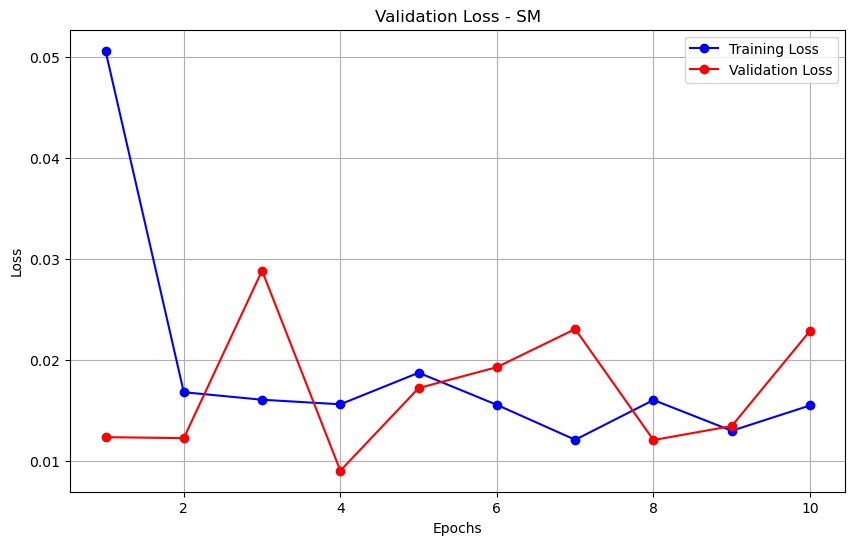

In [181]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history["train_actevap"]
val_loss = sm_metric_history["val_actevap"]

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Inference

In [191]:
Xd_all, Xs_all, Y_all, *_  = preprocess(forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [192]:
# inference 
yhat = predict(Xd_all, Xs_all, model, spatial_batch_size, device)
yhat.shape

(1452, 1827, 2)

In [193]:
lat, lon, time = X.shape[:-1]
lat*lon ,time

(1452, 1827)

In [199]:
y_target, y_pred = prepare_for_plotting(y_target=Y_all[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords = targets.coords)
y_target.shape

(44, 33, 1827)

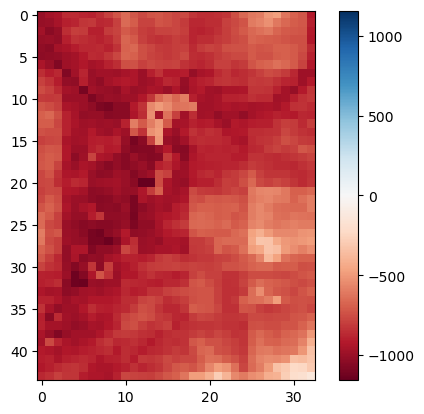

In [200]:
map_bias(y_target, y_pred)

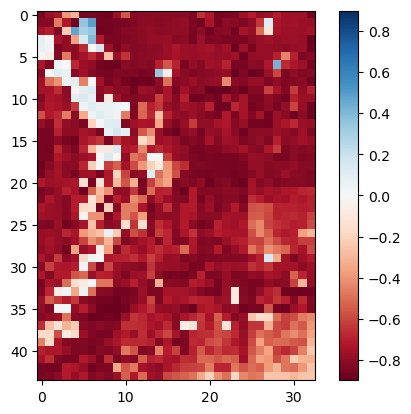

In [201]:
map_pearson(y_target, y_pred)

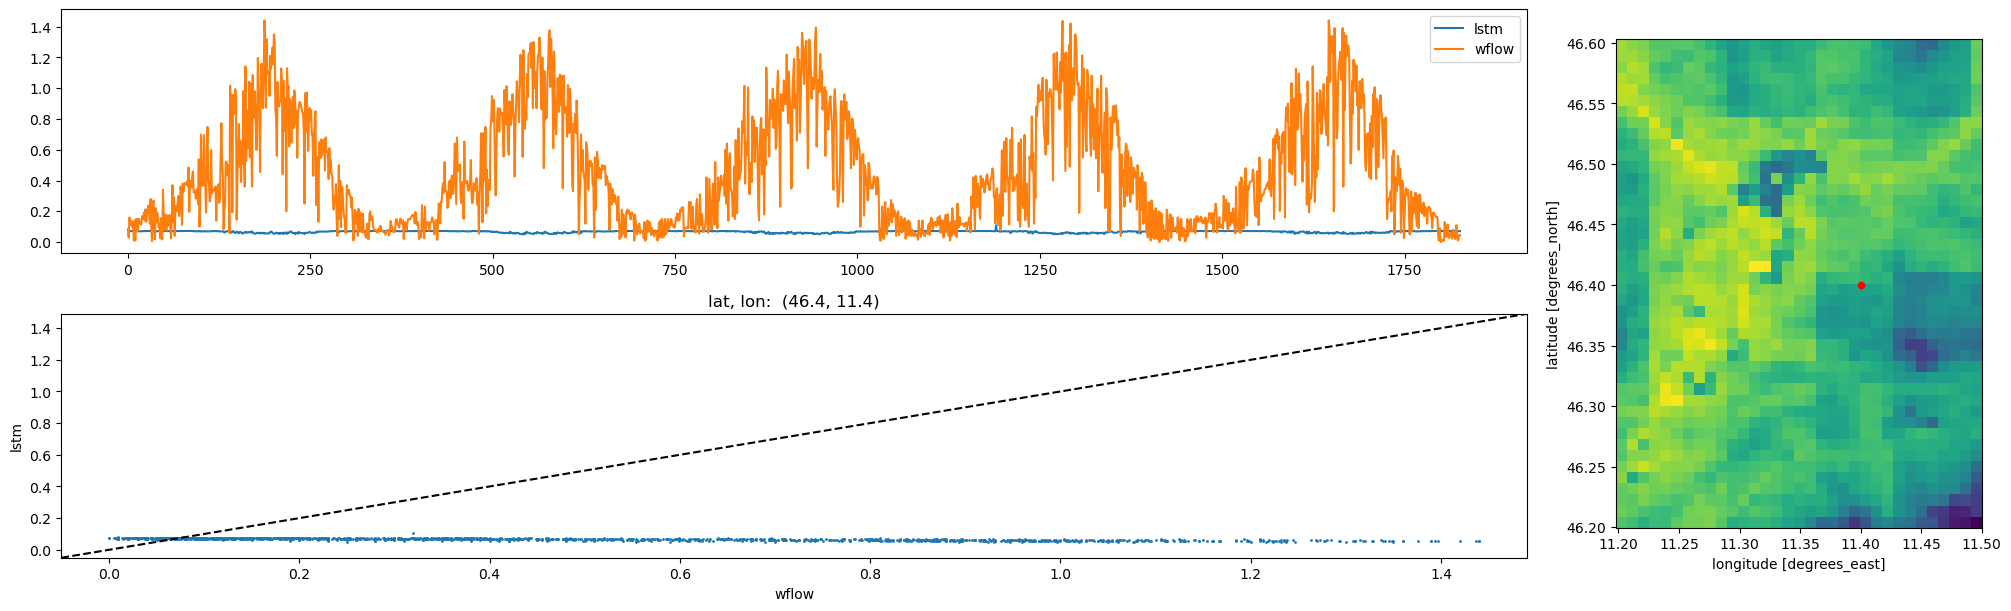

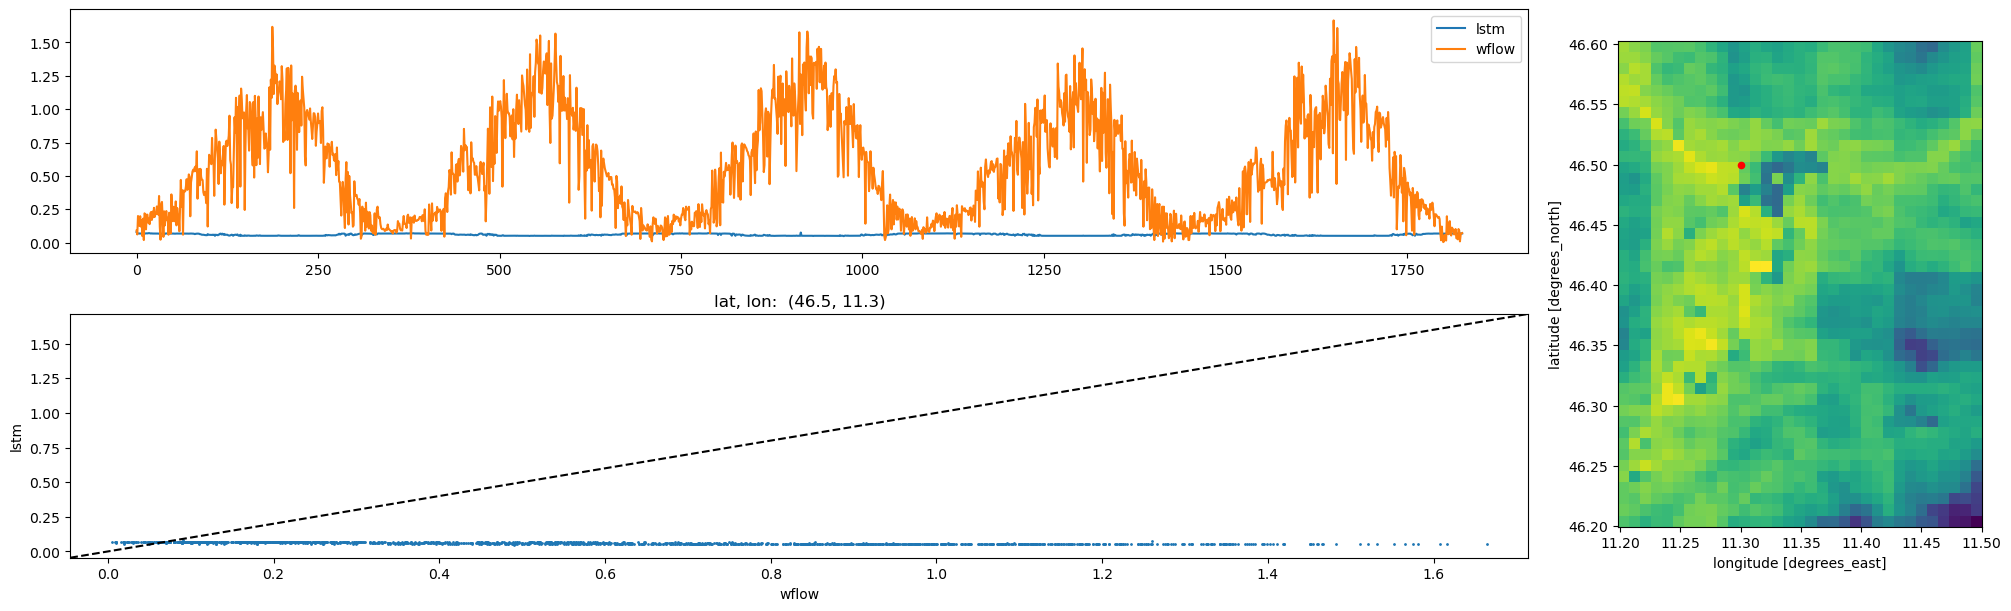

In [202]:
ts_compare(y_target, y_pred, lat = [46.4, 46.5], lon = [11.4, 11.3])